# PairOT Tutorial

In [1]:
# Allow JAX to use all available GPU memory
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.99

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.99


In [2]:
from pathlib import Path

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from IPython.display import display, Image

## 0. Required software and data

**Docker containers:**
  * pairOT Docker container: https://hub.docker.com/repository/docker/felix0097/pairot/general
  * `docker pull felix0097/pairot:full_v1`

**Datasets:**
  * Van der Wijst (Query dataset): https://cellxgene.cziscience.com/collections/7d7cabfd-1d1f-40af-96b7-26a0825a306d
  * Asian Immune Diversity Atlas (Reference dataset): https://celltype.info/project/336/dataset/591/label/71663

**Required Hardware:**
  * We recommend a GPU with at least 40GB of VRAM
  * We used a Nvidia A40 GPU for this tutorial (48GB VRAM)
  * Moreover, for the `Data preparation` section, we recommend around 200GB of system memory

## 1. Data preparation

In [3]:
from pairot.pp import preprocess_adatas
from pairot.pp import OFFICIAL_GENES, FILTERED_GENES

In [4]:
query_dataset = "7d7cabfd-1d1f-40af-96b7-26a0825a306d"
ref_dataset = "ced320a1-29f3-47c1-a735-513c7084d508_CAP"

raw_data_path = Path("/vol/data/dataset-similarity/preprocessed")
preproc_data_path = Path("/vol/data/dataset-similarity/cache")

In [5]:
# Load h5ad files
adata_query = sc.read_h5ad(raw_data_path / f"{query_dataset}.h5ad")
adata_ref = sc.read_h5ad(raw_data_path / f"{ref_dataset}.h5ad")

**Gene space alignment:**
* SConnect only takes genes into account that are expressed in both the query and reference dataset. Hence, it is crucial that gene names are uniform across both datasets.
* Genes should be named in accordance with the gene names listed on [genenames.org](https://genenames.org/tools/search/#!/?query=&filter=document_type:gene)


**Filtering of differentially expressed genes:**
* We filter out uninformative genes from the differentially expression testing results.
* Hence, it is crucial that the gene names used are in accordance with the gene names listed on [genenames.org](https://genenames.org/tools/search/#!/?query=&filter=document_type:gene)
* We use two filters:
  * We subset all genes to the genes listed in `OFFICIAL_GENES["feature_name"]`
  * We filter out uninformative genes listed in `FILTERED_GENES["feature_name"]`

In [6]:
# All DEGs (differentially expressed genes) are subset to the genes list in OFFICAL_GENES
# Genes that are not list there are discarded
OFFICIAL_GENES.sample(10, random_state=0).set_index("feature_name")

,origin
feature_name,
RNU6-992P,Approved symbol
C9orf71,Previous symbols
MLIV,Alias symbols
SNX26,Previous symbols
hsa-mir-653,Alias symbols
OR12D1P,Previous symbols
DEFB130B,Approved symbol
LINC00269,Approved symbol
RNA5SP167,Approved symbol


In [7]:
# All DEGs (differentially expressed genes) that are listed in FILTERED_GENES are discarded
# from differential expression testing results
FILTERED_GENES.sample(10, random_state=0).set_index("feature_name")

,origin,filter_type
feature_name,,
KCNMA1-AS2,Approved symbol,IncRNA
KLRK1-AS1,Approved symbol,IncRNA
U3-55K,Alias symbols,ribosomal
RP11-616M22.2,Alias symbols,IncRNA
LINC00900,Approved symbol,IncRNA
MTATP6P27,Approved symbol,mitochondrial
RPL5P30,Approved symbol,ribosomal
C20orf61,Previous symbols,IncRNA
RPSAP46,Approved symbol,ribosomal


In [8]:
# SConnect uses the var.index column
# Here, we use gene names and not ENSEMBLE IDs -> this looks good
adata_query.var

,feature_id
feature_name,
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460
...,...
RP11-484N11.1,ENSG00000288321
ATXN8,ENSG00000288330
RP4-733M16.8,ENSG00000288398


In [9]:
# SConnect uses the var.index column
# Here, we use gene names and not ENSEMBLE IDs -> this looks good
adata_ref.var

,feature_id
feature_name,
TSPAN6,ENSG00000000003
TNMD,ENSG00000000005
DPM1,ENSG00000000419
SCYL3,ENSG00000000457
C1orf112,ENSG00000000460
...,...
RP4-669P10.21,ENSG00000288719
RP11-852E15.3,ENSG00000288720
F8A1,ENSG00000288722


In [10]:
# Let's run some checks before continuing
official_genes = set(OFFICIAL_GENES["feature_name"])


# 1. check that there is a decent overlap in the gene spaces of the two dataset
expressed_genes_query = set(adata_query.var.index[np.array(adata_query.X.sum(axis=0)).flatten() > 0.0].tolist())
expressed_genes_ref = set(adata_ref.var.index[np.array(adata_ref.X.sum(axis=0)).flatten() > 0.0].tolist())
intersection = expressed_genes_query & expressed_genes_ref
print(f"Number of shared genes: {len(intersection)}")


# 2. Fraction of genes names that are in the OFFICIAL_GENES list
print(f"Fraction of genes in official genes list: {len(intersection & official_genes) / len(intersection):.3f}")

Number of shared genes: 18172
Fraction of genes in official genes list: 0.887


In [ ]:
# Preprocess datasets, this includes:
# 1. Aligning/sort gene space
# 2. Do differential expression testing
# 3. Select highly variable genes
adata_query, adata_ref = preprocess_adatas(
    adata_query,
    adata_ref,
    n_top_genes=750,
    cell_type_column_adata1="cell_type_author",
    cell_type_column_adata2="cell_type_author",
    sample_column_adata1="sample_id",
    sample_column_adata2="sample_id",
)
# Cache preprocessed data
adata_query.write_h5ad(preproc_data_path / f"{query_dataset}.h5ad")
adata_ref.write_h5ad(preproc_data_path / f"{ref_dataset}.h5ad")

**Explanation of method parameters:**
* `n_top_genes`: Number of highly variable genes for calculating Spearman correlations
  * Based on the analysis of [Crow et al.](https://www.nature.com/articles/s41467-018-03282-0), values between 250 and 750 work well. Choosing a higher value leads to increased computational cost (linear increase in the number of genes) while keeping the method output mostly the same.
  * Recommended default value: 750
  * This parameter can be used to speed up computation or to save GPU memory.


## 2. Initialize SConnect model

In [5]:
from pairot.align import DatasetMapping

In [6]:
adata_query = ad.read_h5ad(preproc_data_path / f"{query_dataset}.h5ad")
adata_ref = ad.read_h5ad(preproc_data_path / f"{ref_dataset}.h5ad")
# Make sure that the genes have the same order in both dataset
assert adata_query.var.index.equals(adata_ref.var.index)

dataset_map = DatasetMapping(adata_query, adata_ref)

In [7]:
dataset_map.init_geom(
    batch_size=2048,
    epsilon=0.05,
)

**Explanation of method parameters:**
* `batch_size`
  * This purely technical parameter affects the GPU memory usage of SConnect and does NOT affect its output. Given GPU memory limitations, it should be chosen as large as possible to fully utilize GPU compute capacity.
  * If one receives GPU memory errors later in the code, one should reduce the batch_size parameter.
  * (Note: This parameter has nothing to do with single-cell sequencing batches or the “batch size” used in stochastic gradient descent.)
* `epsilon`: regularisation strength of the optimal transport problem
  * This parameter adjusts the regularisation strength of the optimal transport problem.
  * Intuitively, this parameter affects the uncertainty estimates provided by SConnect. The higher ε is, the more conservative the uncertainty parameters become (fewer false positive matches).
  * Recommended default value: 0.05



In [20]:
# We can print the memory usage of the dataset two count matrices of the query and reference dataset
# Those should comfortably fit into GPU memory
# If this is not the case, you should reduce the number of highly variable genes
# Reducing the number of highly variable genes will also speed up computation
# Any value between 250 and 750 should work fairly well

print(f"x size: {dataset_map.geom.x.shape[0] * dataset_map.geom.x.shape[1] * 4 / 1000**3} GB")
print(f"y size: {dataset_map.geom.y.shape[0] * dataset_map.geom.y.shape[1] * 4 / 1000**3} GB")

x size: 1.805190716 GB
y size: 3.801934496 GB


## 3. Model description & initial sanity checks of the input data

**Model description:**

SConnect aims to “align” (or to “connect”) cell-type labels between two datasets from separate studies, suggesting similar clusters or potential matches against the reference dataset for each cell type in the query dataset solely based on the underlying transcriptomic signatures. To achieve this objective, we model each dataset as a point cloud, meaning each data point or cell is associated with a gene expression vector (𝘅) and a cluster / cell-type label (y). Notably, the clustering or grouping information of individual cells uniformly annotated, not the associated string labels, is provided by the cell-type label y. At its core, SConnect uses optimal transport to connect the point cloud distribution of the query dataset with the point cloud from the reference dataset; thus, the method considers the global structure of the data, compared to just finding the closest neighbors in the reference dataset.

The distance between a cell in the query dataset (described by the multi-dimensional gene expression vector $𝘅_1$ and cluster label $y_1$) and a cell in the reference dataset (described by the multi-dimensional gene expression vector $𝘅_2$ and cluster label $y_2$) is split into two parts. The distance measure (also known as the “transport cost”) is the sum between the distance in gene expression space and the distance in label space:
$$
distance((𝘅_1, y_1), (𝘅_2, y_2)) = \lambda_{feature} \cdot distance_{gene\,expression} (𝘅_1, 𝘅_2) + \lambda_{label} \cdot distance_{label}(y_1, y_2)
$$

**Doing an initial sanity check:**

First, looking at the above distance measure, we can do an initial sanity check:

The optimal transport model relies on a predictive distance measure to accurately align cell types between clusters. Hence, as a quick sanity check we can plot the label distance matrix $distance_{label}(y_1, y_2)$ between cell type clusters. The label distance is computed by looking at the similarity of the top XX differentiall-expressed genes (DEGs) between a cluster $y_1$ in the query and a cluster $y_2$ in the reference dataset.

When looking at the label distance matrix, we want to check if we have a predictive signal that can help with cell-type assignments, e.g., that celltypes which one would expect to match across datasets, are also associated with a low distance (high similarity). Note, that those matches do not need to be perfect, as the there is still the distance between individual cells $distance_{gene\,expression} (𝘅_1, 𝘅_2)$. Moreover, one does not need to make assignments based on this initial sanity check, SConnect is going to do this for you, based on the underlying optimal transport model (See `OT mappings` section later in the tutorial).

To give some examples for this initial sanity check, we can see that, indeed, we have a predictive signal that already distinguishes many of the cell types from each other. E.g when looking at the `NK_CD56++`, `B_Naive` or `T4_Treg` clusters from the query dataset.

As a quick sanity check, this looks all good. As both datasets are immune dataset and we would expect quite a few potential matches where the string labels are the same or quite similar.

In [9]:
from pairot.pl import plot_cluster_mapping

In [ ]:
label_distance = dataset_map.label_distance_matrix
# Sort label distance matrix that best matches are on the diagonal to aid visualization
label_distance = label_distance.loc[
    label_distance.min(axis=1).sort_values().index.tolist(),
    label_distance.min().sort_values().index.tolist(),
]

fig = plot_cluster_mapping(label_distance, zmin=0.0, zmax=1.0, colormap="RdYlGn_r", sort_by_score=False)
fig.update_coloraxes(showscale=False)
fig

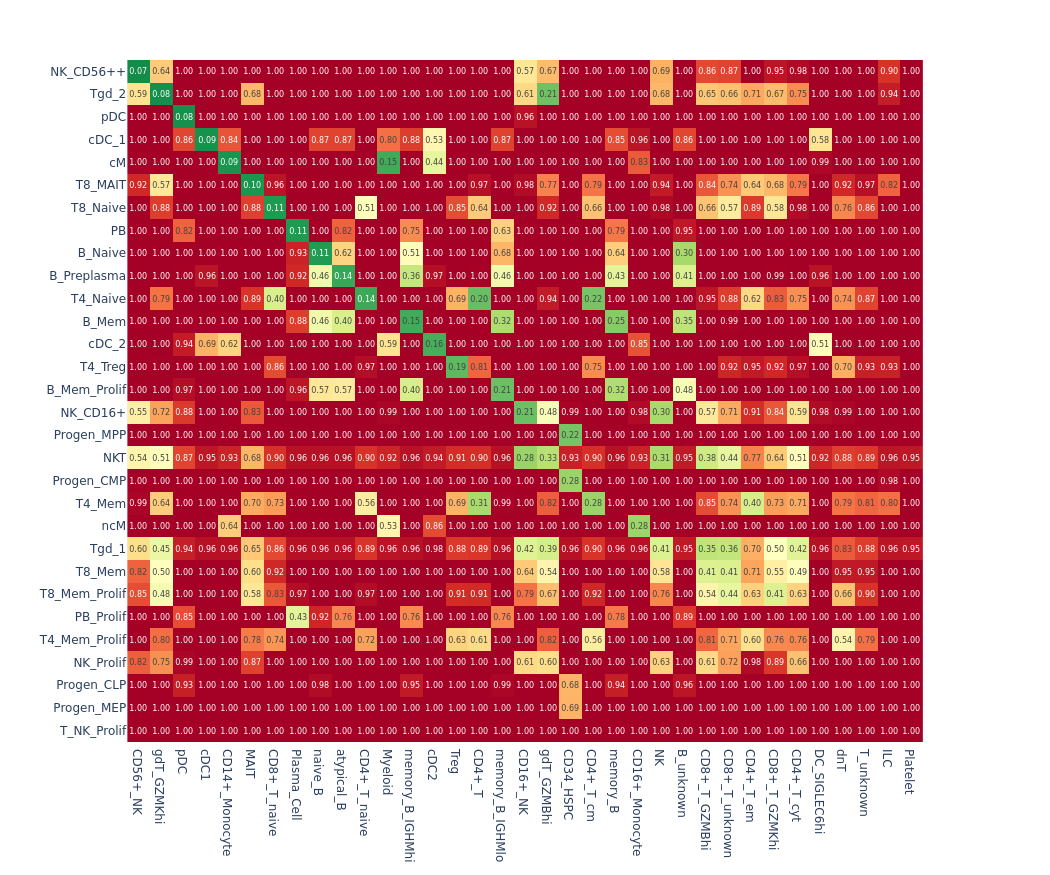

In [34]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("label_distance.png")
display(Image("label_distance.png"))

Additionally, we can look at the DEGs that were used as a basis for the similarity calcualtion to see based on which genes the similarity between clusters is calcualted and whether those genes are biologically meaningful. Let's look at two examples:
* `cM` &rarr; `CD14+_Monocyte`: Here we can see many CD14+ Monocyte markers, e.g.: `CD14`, `S100A12`, `S100A8`, `S100A9`
*  `T4_Treg` &rarr; `Treg`: Here we can see many CD4 T Regulatory cell markers, e.g.: `FOXP3`, `RTKN2`, `IL32`, `CTLA4`, `IL2RA`

Again, we can see that the method input, indeed, makes sense.

In [22]:
COLUMNS_TO_SHOW = ["rank_query", "logFC_query", "rank_ref", "logFC_ref"]

with pd.option_context("display.precision", 2):
    display(dataset_map.DEGs_label_distance_matrix["cM"]["CD14+_Monocyte"][COLUMNS_TO_SHOW])

,rank_query,logFC_query,rank_ref,logFC_ref
gene,,,,
S100A8,0,4.81,0,5.68
S100A9,1,4.80,1,5.54
S100A12,2,4.55,5,4.23
LYZ,3,4.19,2,4.98
FCN1,4,4.15,3,4.39
CD14,5,4.02,7,3.86
VCAN,6,3.91,4,4.32
SERPINA1,7,3.69,10,3.64
CSTA,8,3.40,15,3.50


In [12]:
with pd.option_context("display.precision", 2):
    display(dataset_map.DEGs_label_distance_matrix["T4_Treg"]["Treg"][COLUMNS_TO_SHOW])

,rank_query,logFC_query,rank_ref,logFC_ref
gene,,,,
FOXP3,0,3.06,0.0,3.31
RTKN2,1,2.93,3.0,2.53
IL32,2,2.84,2.0,2.56
CTLA4,3,2.54,1.0,2.78
IL2RA,4,2.51,6.0,2.21
MAL,5,2.35,7.0,2.15
CD3D,6,2.26,10.0,2.04
TIGIT,7,2.20,8.0,2.11
TNFRSF4,8,2.16,NaN,NaN


## 4. Fit SConnect model

In [13]:
dataset_map.init_problem(tau_a=1.0, tau_b=1.0)

**Explanation of method parameters:**
* `tau_*`: imbalance parameter of the optimal transport problem
  * If one expects a low overlap between cell type labels of the two datasets, this can be set lower; a starting point would be to set 𝜏  between 0.95 and 0.975.
  * Note: If tau < 1., the mapping/similarity scores can be larger than 1. One should increase the unbalancedness parameter tau if values are far higher than 1.
  * Recommended default: 1.0
  * Recommended default (low overlap in cell type annotations): 0.95 - 0.975

**See OTT-JAX documentation for more details:**
* https://ott-jax.readthedocs.io/en/latest/problems/_autosummary/ott.problems.linear.linear_problem.LinearProblem.html#ott.problems.linear.linear_problem.LinearProblem
* https://ott-jax.readthedocs.io/en/latest/tutorials/linear/800_Unbalanced_OT.html

In [14]:
dataset_map.solve()

  6%|████████▋                                                                                                                                       | 12/200 [4:37:10<72:22:23, 1385.87s/it, error: 8.019218e-04]


## 5. Interpreting results of SConnect

In [15]:
from pairot.pl import plot_cluster_mapping, plot_cluster_distance

#### OT mappings

This the main output of SConnect, the cluster_mapping matrix shows where the cells aggregated by cell-type cluster from the query dataset get mapped to in the reference dataset. Thus, showing to the user which clusters are most similar.

In [16]:
cluster_mapping = dataset_map.compute_cluster_mapping(aggregation_method="mean")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [34:41<00:00, 69.38s/it]


In [ ]:
fig = plot_cluster_mapping(cluster_mapping)
# Interactive plotly plot isn't shown on GitHub
fig

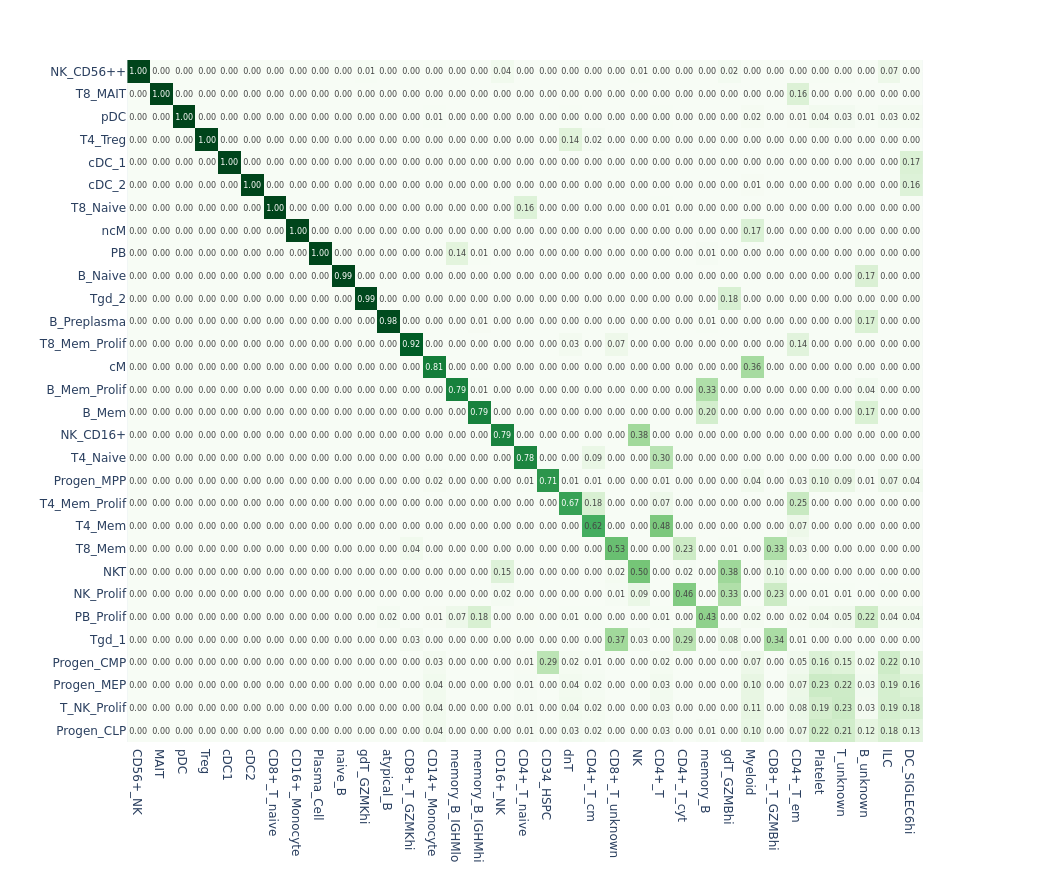

In [28]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_mapping.png")
display(Image("cluster_mapping.png"))

#### Cluster distance

As an additional output, we can also look at the distance between cell-type clusters. This shows to the user how "close" or similar individual clusters are. This can be used as an additional sanity check, two clusters might be most similar based on the cluster_mapping matrix. However, they might still have a high distance between them. This should be seen as an indication to the user that such a match should be investigated in more detail.

In [18]:
cluster_distance = dataset_map.compute_cluster_distances()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [09:53<00:00,  1.77it/s]


In [ ]:
# Sort cluster distances by mapping scores as well
cluster_distance = cluster_distance.loc[
    cluster_mapping.max(axis=1).sort_values(ascending=False).index.tolist(),
    cluster_mapping.max().sort_values(ascending=False).index.tolist(),
]
fig = plot_cluster_distance(cluster_distance)
# Interactive plotly plot isn't shown on GitHub
fig

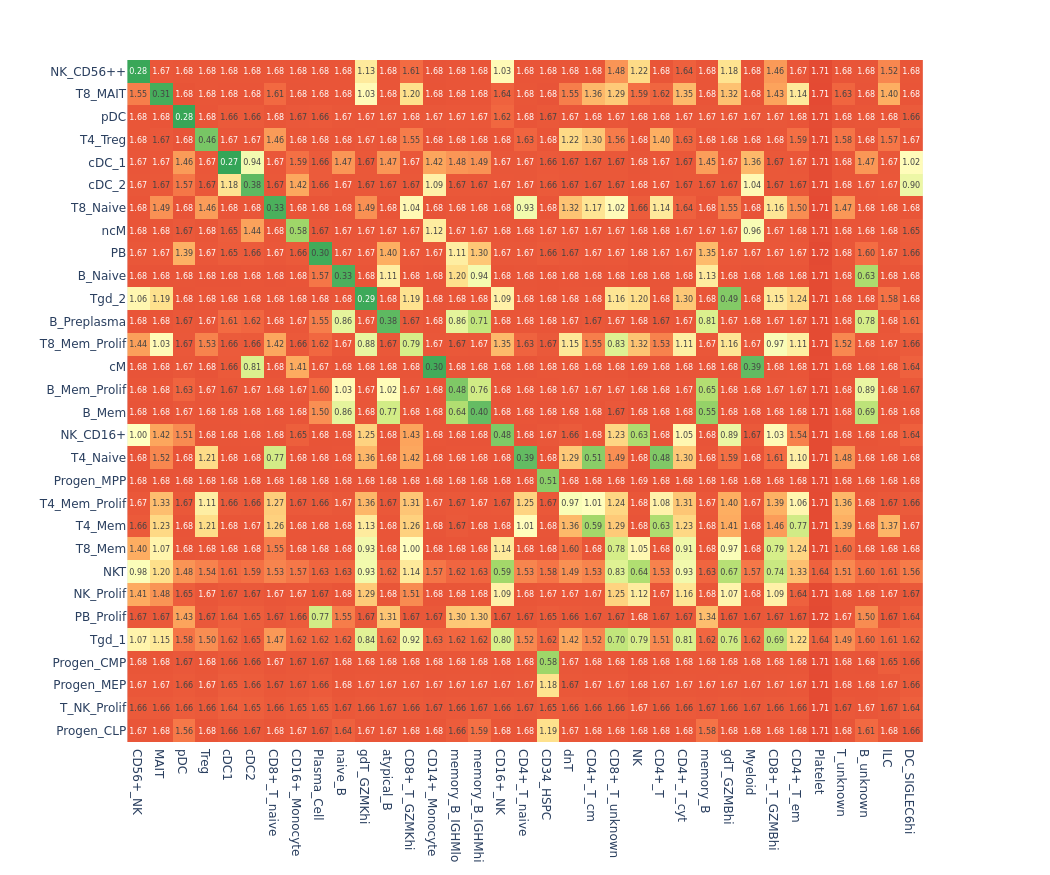

In [32]:
# Show output as PNG image that it gets rendered on GitHub
fig.write_image("cluster_distance.png")
display(Image("cluster_distance.png"))